In [1]:
import numpy as np, analysis as ana, plottools as pl, prjlib
from matplotlib.pyplot import *
from scipy.optimize import curve_fit

In [2]:
def likefunc(A,c0,c1,mscb,icov,bi=0):
    bn = np.shape(mscb)
    return np.exp(ana.lnLHL(A/c0*np.ones(bn),c1*mscb,icov,bi))

def fitlikefunc(xdat,ydat,yerr,mscb,icov,c1=None,bi=0):
    bn = np.shape(mscb)
    index = np.where(yerr==0.)
    x = np.delete(xdat,index)
    y = np.delete(ydat,index)
    s = np.delete(yerr,index)
    if c1 is None:
        like = lambda x, c0, c1: np.exp(ana.lnLHLs(x/c0,c1*mscb,icov,bi))
        p, __ = curve_fit(like,x,y,sigma=s,p0=[1.,1.])
        return p[0], p[1]
    else:
        like = lambda x, c0: np.exp(ana.lnLHLs(x/c0,mscb,icov,bi))
        p, __ = curve_fit(like,x,y,sigma=s,p0=[1.])
        return p[0]

In [3]:
# prepare data
def loaddata(bn,lmin,Acb,ver,rlmin='200',patch='deep56',simn=100): #output binned spectra
    ps, __ = prjlib.filename_init(rlmin=rlmin,stype='lcmb',PSA='s14&15_'+patch,doreal='True',dearot='True',ver=ver)
    if Acb=='0.0':
        pa = ps
    else:
        pa, __ = prjlib.filename_init(rlmin=rlmin,stype='a'+str(Acb).replace('.','p'),PSA='s14&15_deep56')
    pA, __ = prjlib.filename_init(rlmin=rlmin,stype='a0p3',PSA='s14&15_deep56')
    mb, mb0, mb1 = prjlib.binning_all(bn,lmin=lmin,Lsp=2048)
    sn0b = prjlib.binned_cl(ps.quad.f['EB'].n0bs,mb0,mb1)
    an0b = prjlib.binned_cl(pa.quad.f['EB'].n0bs,mb0,mb1)
    scb = prjlib.binned_cl_rlz(ps.quad.f['EB'].cl,1,200,mb0,mb1) + sn0b[None,:]
    acb = prjlib.binned_cl_rlz(pa.quad.f['EB'].cl,1,simn,mb0,mb1) + sn0b[None,:]
    Acb = prjlib.binned_cl_rlz(pA.quad.f['EB'].cl,1,simn,mb0,mb1) + sn0b[None,:]
    ocb = prjlib.binned_cl(ps.quad.f['EB'].cl[0],mb0,mb1) + sn0b
    macb = np.mean(acb,axis=0)
    mscb = np.mean(scb[simn:],axis=0)
    dacb = (np.mean(Acb,axis=0)-mscb)/3. # scale to ACB = 0.1 case
    icov = ana.get_cov(scb[simn:],cinv=True)
    return mb, ocb, scb, mscb, acb, macb, dacb, icov

In [4]:
def fit_c0c1(Ab,mscb,icov,histbn=None,lmin=20,do_plot=False):
    # output c0 and c1
    nv = np.shape(Ab)[0]
    bn = np.shape(Ab)[1]
    c0 = np.zeros(bn)
    c1 = np.zeros(bn)
    if histbn is None:
        histbn = np.int(np.sqrt(nv))
    for bi in range(bn):
        N, be = np.histogram(Ab[:,bi],bins=histbn)
        An = (be[1:]+be[:-1])*.5
        if bi<=5: # well fitted by assuming c1=1
            c0[bi] = fitlikefunc(An,N/np.max(N),np.sqrt(N)/np.max(N),mscb,icov,c1=1.,bi=bi)
            c1[bi] = 1.
        else: # need c1 (variance) correction due to off-diagonal correlation between bins
            c0[bi], c1[bi] = fitlikefunc(An,N/np.max(N),np.sqrt(N)/np.max(N),mscb,icov,bi=bi) # fit likelihood

        if do_plot:
            pl.hist_errorbars(Ab[:,bi],fsize=[4,3],bins=histbn,ymax=1.2)
            A = np.arange(np.min(Ab[:,bi]),np.max(Ab[:,bi]),(np.max(Ab[:,bi])-np.min(Ab[:,bi]))/50.)
            Lh = np.array([likefunc(a,c0[bi],c1[bi],mscb,icov,bi) for a in A])
            plot(A,Lh/np.max(Lh),'r-',label='HL,c0='+str(c0[bi])[:4]+',c1='+str(c1[bi])[:4])
            legend(loc=0,frameon=False)
            show()
            clf()

    return c0,c1

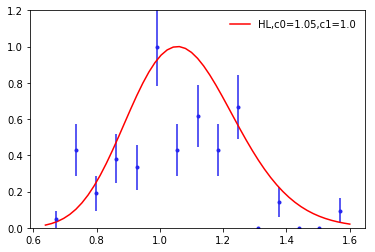

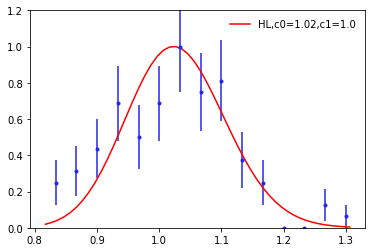

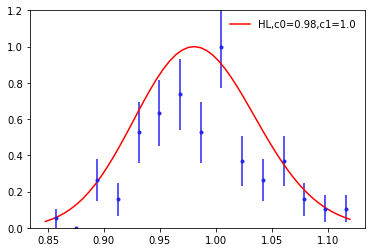

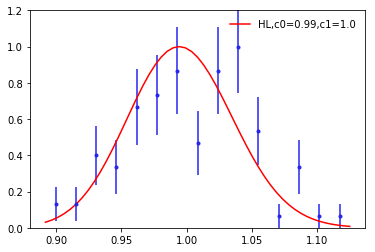

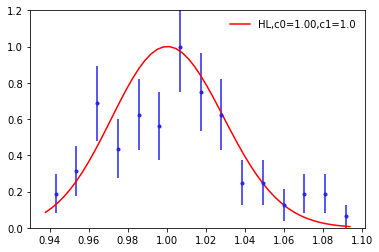

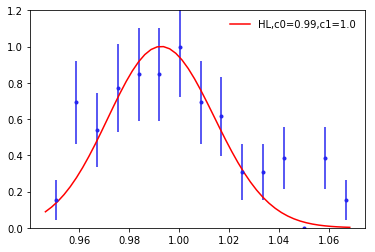

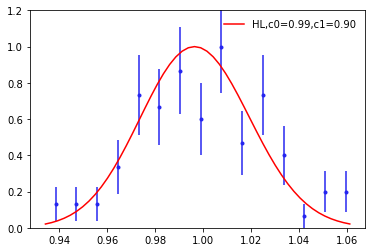

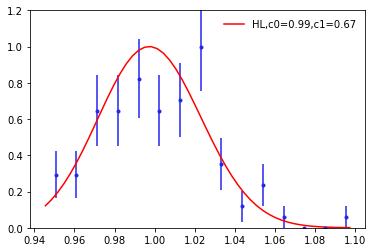

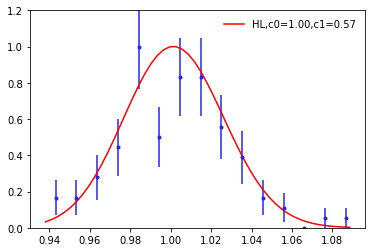

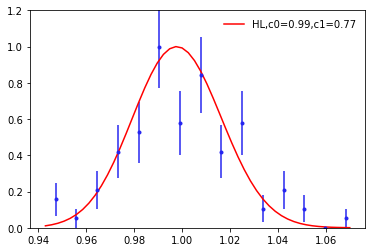

1.0556322920872512 1.0


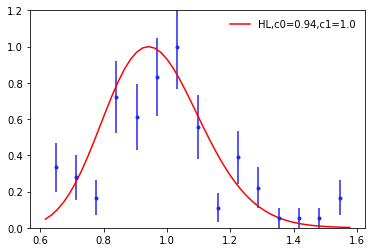

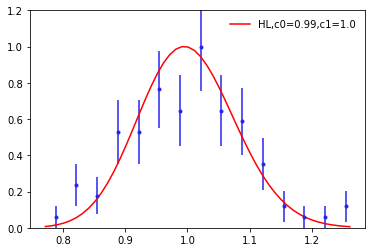

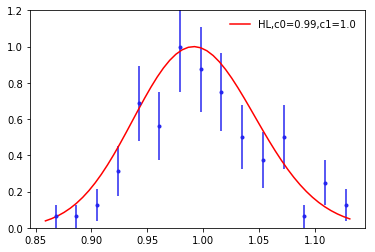

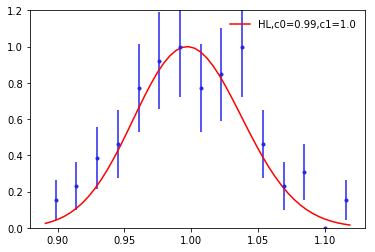

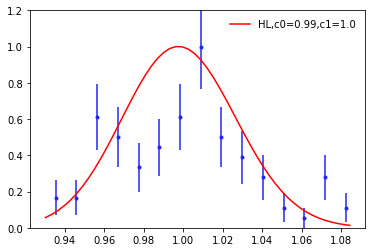

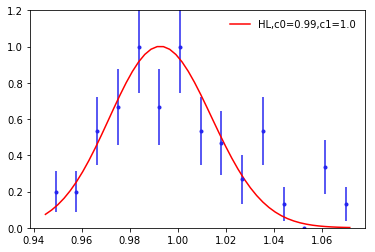

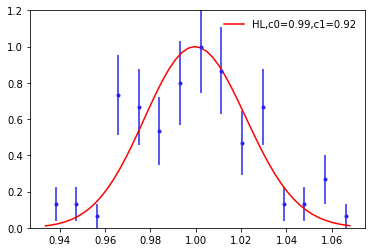

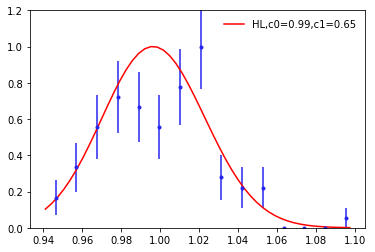

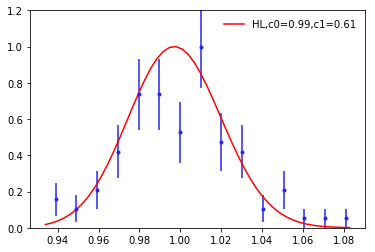

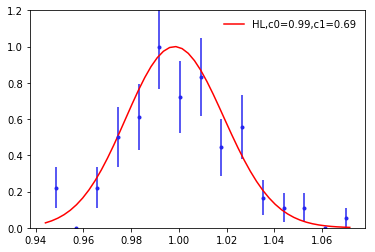

0.9417099923192016 1.0


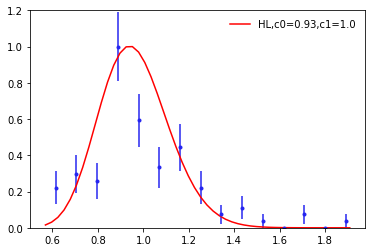

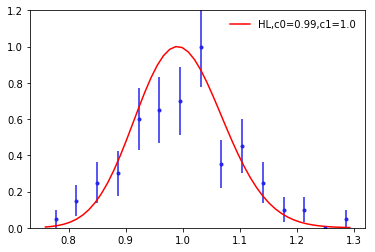

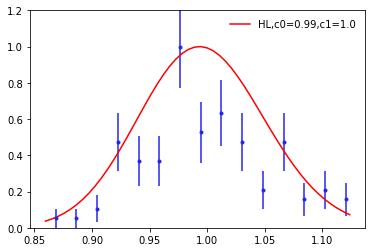

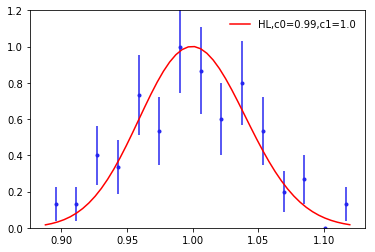

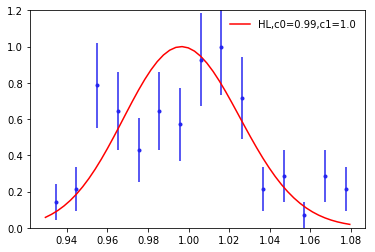

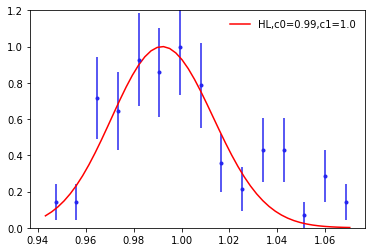

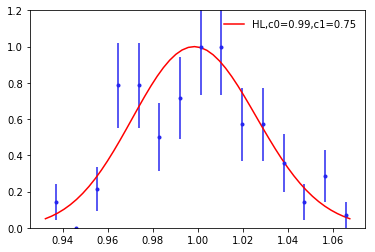

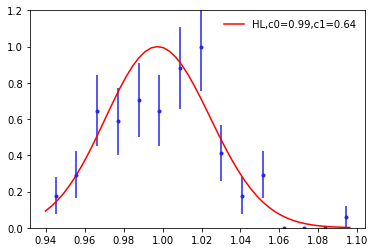

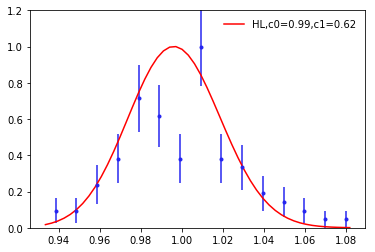

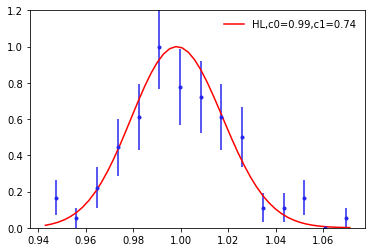

0.9392472593851681 1.0


<Figure size 432x288 with 0 Axes>

In [5]:
simn = 100
As = np.array([0.0,0.1,0.3])
c0 = np.zeros((len(As),10))
c1 = np.zeros((len(As),10))
for i, Acb in enumerate(As):
    # load data
    mb, ocb, scb, mscb, acb, macb, dacb, icov =loaddata(10,lmin=20,Acb=str(Acb),ver='v1',rlmin='200',simn=simn)
    # fit c0 and c1
    if Acb == 0.0:
        Ab = scb[:simn,:]/mscb[None,:]
    else:
        Ab = acb[:simn,:]/macb[None,:]
    c0[i,:], c1[i,:] = fit_c0c1(Ab,mscb,icov,histbn=15,lmin=20,do_plot=True)
    print(c0[i,0],c1[i,0])

0.104 0.116 0.127


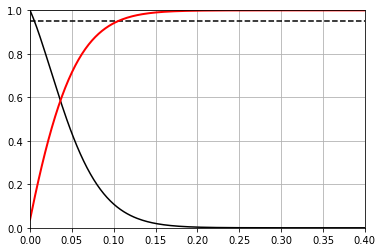

In [6]:
ai = 0
bmin, bmax = 0, 9
A = np.arange(0.,1.,0.002)
Ai = np.zeros(100)
CL = np.zeros(100)
ylim(0,1)
xlim(0,0.4)
grid(True)
axhline(0.95,color='k',ls='--')
for i in range(100):
    Lh = prjlib.posterior(A,scb[i,:],mscb,dacb,icov,c0[ai,:],c1[ai,:],bmin,bmax)
    if i==0: Lh = prjlib.posterior(A,ocb,mscb,dacb,icov,c0[ai,:],c1[ai,:],bmin,bmax)
    if i==0: plot(A,Lh/np.max(Lh),'k-')
    CDF = np.cumsum(Lh)/np.sum(Lh)
    if i==0: plot(A,CDF,'r-',lw=2)
    Ai[i] = A[np.argmax(Lh)]
    CL[i] = A[np.abs(CDF-0.95).argmin()]

print(str(CL[0])[:5],str(np.median(CL[1:]))[:5],str(np.mean(CL[1:]))[:5])
#savefig('fig_pdf.png')